In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_percentage_error
import warnings
import time
warnings.filterwarnings('ignore')

## IMPORT DATASET

In [2]:
data = pd.read_csv('jabodetabek_house_price copy.csv')
data.head()

,url,price_in_rp,title,address,district,city,lat,long,facilities,property_type,...,electricity,maid_bedrooms,maid_bathrooms,floors,building_age,year_built,property_condition,building_orientation,garages,furnishing
0,https://www.rumah123.com/properti/bekasi/hos11...,2.990000e+09,Rumah cantik Sumarecon Bekasi\nLingkungan asri...,"Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,"Tempat Jemuran, Jalur Telepon, Taman, Taman",rumah,...,4400 mah,0.0,1.0,2.0,5.0,2017.0,bagus,NaN,0.0,unfurnished
1,https://www.rumah123.com/properti/bekasi/hos10...,1.270000e+09,"Rumah Kekinian, Magenta Summarecon Bekasi","Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,Taman,rumah,...,2200 mah,0.0,0.0,2.0,NaN,NaN,bagus,NaN,0.0,NaN
2,https://www.rumah123.com/properti/bekasi/hos10...,1.950000e+09,Rumah Cantik 2 Lantai Cluster Bluebell Summare...,"Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,"Jogging Track, Kolam Renang, Masjid, Taman,...",rumah,...,2200 mah,1.0,1.0,2.0,NaN,NaN,bagus,NaN,1.0,unfurnished
3,https://www.rumah123.com/properti/bekasi/hos10...,3.300000e+09,Rumah Mewah 2Lantai L10x18 C di Cluster VERNON...,"Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,"Jalur Telepon, Jogging Track, Track Lari, K...",rumah,...,3500 mah,1.0,1.0,2.0,6.0,2016.0,bagus sekali,utara,2.0,unfurnished
4,https://www.rumah123.com/properti/bekasi/hos10...,4.500000e+09,"Rumah Hoek di Cluster Maple Summarecon Bekasi,...","Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,"Jogging Track, Kolam Renang, Taman, Jalur Te...",rumah,...,3500 mah,1.0,1.0,2.0,9.0,2013.0,bagus,utara,1.0,unfurnished


In [3]:
data.address.value_counts()

address
Sentul City, Bogor                   282
Alam Sutera, Tangerang               115
Gading Serpong, Tangerang             97
Pantai Indah Kapuk, Jakarta Utara     94
BSD, Tangerang                        83
                                    ... 
Fatmawati, Jakarta Selatan             1
Ragunan, Jakarta Selatan               1
Radio Dalam, Jakarta Selatan           1
Raffles Hills, Jakarta Timur           1
Sudimara, Tangerang                    1
Name: count, Length: 397, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   url                   3553 non-null   object 
 1   price_in_rp           3553 non-null   float64
 2   title                 3553 non-null   object 
 3   address               3553 non-null   object 
 4   district              3553 non-null   object 
 5   city                  3553 non-null   object 
 6   lat                   3553 non-null   float64
 7   long                  3553 non-null   float64
 8   facilities            3553 non-null   object 
 9   property_type         3552 non-null   object 
 10  ads_id                3549 non-null   object 
 11  bedrooms              3519 non-null   float64
 12  bathrooms             3524 non-null   float64
 13  land_size_m2          3551 non-null   float64
 14  building_size_m2      3551 non-null   float64
 15  carports             

## PREPROCESSING

In [6]:
def data_imputation(data):
    data = data.copy()
    data['bedrooms'] = data['bedrooms'].fillna(data['bedrooms'].mean()).astype(int)
    data['bathrooms'] = data['bathrooms'].fillna(data['bathrooms'].mean()).astype(int)
    data['land_size_m2'] = data['land_size_m2'].fillna(data['land_size_m2'].mean())
    data['building_size_m2'] = data['building_size_m2'].fillna(data['building_size_m2'].mean())
    data['floors'] = data['floors'].fillna(data['floors'].mean()).astype(int)
    data['building_age'] = data['building_age'].fillna(data['building_age'].mean()).astype(int)
    data['year_built'] = data['year_built'].fillna(data['year_built'].mean()).astype(int)
    data['property_condition'] = data['property_condition'].fillna(data['property_condition'].mode()[0])
    data['certificate'] = data['certificate'].fillna(data['certificate'].mode()[0])
    
    data['facilities_list'] = data['facilities'].apply(lambda x: x.split(','))
    unique_facilities = set(facility.strip() for facility_list in data['facilities_list'] for facility in facility_list)
    for facility in unique_facilities:
        data[facility] = data['facilities_list'].apply(lambda x: 1 if facility in [f.strip() for f in x] else 0)
    
    return data

In [7]:
def feature_engineering(data):
    data = data.copy()
    data['electricity'] = data['electricity'].str.extract('(\d+)')
    data['electricity'] = data['electricity'].fillna(data['electricity'].mode()[0]).astype(int)
    
    mapping = {
    "bagus": 3,
    "baru": 4,
    "bagus sekali": 4,
    "sudah renovasi": 2,
    "butuh renovasi": 0,
    "unfurnished": 1,
    "semi furnished": 3
    }
    
    data['property_condition'] = data['property_condition'].apply(lambda x: mapping[x])
    data['furnishing'] = data['furnishing'].apply(lambda x: 2 if x == 'furnished' or x == 'baru' else 1 if x == 'semi furnished' else 0)
    
    object_cols = data.select_dtypes(include=['object']).columns.tolist()
    for col in object_cols:
        if col != 'facilities_list':
            data[col] = data[col].astype('category')
    
    return data

In [8]:
def drop_columns(data):
    data = data.copy()
    data = data.drop(['url',
                      'property_type',
                      'ads_id',
                      'title',
                      'address',
                      'building_orientation',
                      'facilities',
                      'facilities_list',
                      ], axis=1)
    return data

In [9]:
data_pipe = drop_columns(feature_engineering(data_imputation(data)))
X = data_pipe.drop('price_in_rp', axis=1)
y = data_pipe['price_in_rp']

In [10]:
data_pipe.head()

,price_in_rp,district,city,lat,long,bedrooms,bathrooms,land_size_m2,building_size_m2,carports,...,Water heater,Dapur bersih dan kotor,Servis Area,Garasi,Playground,one gate sistem,Masjid,torrent,Keamanan,Track Lari
0,2.990000e+09,Summarecon Bekasi,Bekasi,-6.223945,106.986275,4,4,239.0,272.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.270000e+09,Summarecon Bekasi,Bekasi,-6.223945,106.986275,3,2,55.0,69.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,1.950000e+09,Summarecon Bekasi,Bekasi,-6.223945,106.986275,3,3,119.0,131.0,1.0,...,0,0,0,0,0,0,1,0,1,0
3,3.300000e+09,Summarecon Bekasi,Bekasi,-6.223945,106.986275,3,3,180.0,174.0,0.0,...,0,0,0,0,0,0,0,0,1,1
4,4.500000e+09,Summarecon Bekasi,Bekasi,-6.223945,106.986275,4,3,328.0,196.0,2.0,...,0,0,0,0,0,0,0,0,1,0


In [21]:
X.head()

,district,city,lat,long,bedrooms,bathrooms,land_size_m2,building_size_m2,carports,certificate,...,Water heater,Dapur bersih dan kotor,Servis Area,Garasi,Playground,one gate sistem,Masjid,torrent,Keamanan,Track Lari
0,Summarecon Bekasi,Bekasi,-6.223945,106.986275,4,4,239.0,272.0,0.0,shm - sertifikat hak milik,...,0,0,0,0,0,0,0,0,0,0
1,Summarecon Bekasi,Bekasi,-6.223945,106.986275,3,2,55.0,69.0,1.0,hgb - hak guna bangunan,...,0,0,0,0,0,0,0,0,0,0
2,Summarecon Bekasi,Bekasi,-6.223945,106.986275,3,3,119.0,131.0,1.0,hgb - hak guna bangunan,...,0,0,0,0,0,0,1,0,1,0
3,Summarecon Bekasi,Bekasi,-6.223945,106.986275,3,3,180.0,174.0,0.0,shm - sertifikat hak milik,...,0,0,0,0,0,0,0,0,1,1
4,Summarecon Bekasi,Bekasi,-6.223945,106.986275,4,3,328.0,196.0,2.0,shm - sertifikat hak milik,...,0,0,0,0,0,0,0,0,1,0


In [11]:
columns = data_pipe.columns
object_columns = data_pipe.select_dtypes(include='object').columns
numerical_columns = data_pipe.select_dtypes(exclude='object').columns

## IMPLEMENT PCA

In [12]:
import numpy as np
import pandas as pd

def pca_with_svd(data, n_components=None):
    """

    Melakukan PCA menggunakan Singular Value Decomposition (SVD) pada kolom numerik.
    
    Parameter:
    - data: pd.DataFrame
        DataFrame input.
    - n_components: int atau None
        Jumlah komponen utama yang akan disimpan. Jika None, maka semua komponen akan disimpan.

    Keluaran:
    - dict
        Sebuah dictionary yang berisi:
        - 'pca_svd': Data yang diproyeksikan menggunakan SVD,
        - 'explained_variance': Rasio varians yang dijelaskan,
        - 'components': Komponen utama (vektor singular kanan).
    """
    start_time = time.time()
    # Memilih kolom numerik
    numerical_data = data.select_dtypes(include=[np.number])
    if numerical_data.empty:
        raise ValueError("No numerical data found for PCA.")

    # Standardisasi data
    standardized_data = (numerical_data - numerical_data.mean()) / numerical_data.std()

    # Dekompisisi SVD
    U, Sigma, Vt = np.linalg.svd(standardized_data, full_matrices=False)
    
    # Menerapkan jumlah komponen yang diinginkan
    n_components = n_components or standardized_data.shape[1]
    
    # Proyeksi data ke ruang komponen utama
    pca_svd = U[:, :n_components] @ np.diag(Sigma[:n_components])

    # Menmasukkan PCA ke dalam DataFrame
    pca_column_names = [f"PC{i+1}" for i in range(n_components)]

    # Membuat DataFrame baru
    pca_df = pd.DataFrame(pca_svd, columns=pca_column_names, index=data.index)
    non_numerical_data = data.drop(columns=numerical_data.columns)  # Menyimpan kolom non-numerik

    # Menggabungkan data
    updated_data = pd.concat([non_numerical_data, pca_df], axis=1)
    execution_time = time.time() - start_time
    
    print(f"PCA with SVD completed in {execution_time:.2f} seconds.")

    return updated_data


In [13]:
import numpy as np
import pandas as pd

def pca_with_covariance(data, n_components=None):
    """
    Melakukan PCA menggunakan matriks kovariansi pada kolom numerik.

    Parameter:
    - data: pd.DataFrame
        DataFrame input.
    - n_components: int atau None
        Jumlah komponen utama yang akan disimpan. Jika None, maka semua komponen akan disimpan.

    Keluaran:
    - pd.DataFrame
        DataFrame yang diperbarui dengan data numerik digantikan oleh komponen utama (PCA).
    """
    start_time = time.time()
    # Memilih kolom numerik
    numerical_data = data.select_dtypes(include=[np.number])
    if numerical_data.empty:
        raise ValueError("No numerical data found for PCA.")

    # Standardisasi data
    standardized_data = (numerical_data - numerical_data.mean()) / numerical_data.std()

    # Membuat matriks kovariansi
    covariance_matrix = np.cov(standardized_data.T)

    # Menghitung eigenvalues dan eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)

    # Mengurutkan eigenvalues dan eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Menentukan jumlah komponen yang diinginkan
    n_components = n_components or standardized_data.shape[1]

    # Memilih n komponen teratas
    selected_eigenvectors = eigenvectors[:, :n_components]

    # Proyeksi data ke ruang komponen utama
    pca_covariance = standardized_data @ selected_eigenvectors

    # Membuat nama kolom untuk komponen utama
    pca_column_names = [f"PC{i+1}" for i in range(n_components)]

    # Membuat DataFrame baru untuk komponen utama
    pca_df = pd.DataFrame(pca_covariance, index=data.index)
    pca_df.columns = pca_column_names

    # Menyimpan kolom non-numerik
    non_numerical_data = data.drop(columns=numerical_data.columns)

    # Menggabungkan kembali data non-numerik dan komponen utama
    updated_data = pd.concat([non_numerical_data, pca_df], axis=1)
    execution_time = time.time() - start_time
    
    print(f"PCA with covariance completed in {execution_time:.2f} seconds.")

    return updated_data

In [14]:
data_pca_svd = pca_with_svd(data_pipe, n_components=15)
data_pca_covariance = pca_with_covariance(data_pipe, n_components=15)

PCA with SVD completed in 0.10 seconds.
PCA with covariance completed in 0.05 seconds.


In [15]:
data_pca_svd.head()

,district,city,certificate,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,Summarecon Bekasi,Bekasi,shm - sertifikat hak milik,0.988203,0.140249,0.033376,0.428456,-0.033197,0.007668,-0.039236,-0.135429,0.146518,-0.120047,-0.212164,-1.332387,0.525046,-0.050129,0.076462
1,Summarecon Bekasi,Bekasi,hgb - hak guna bangunan,2.040218,0.213326,0.176250,-0.944965,-0.063106,-0.052623,-0.092101,-0.103311,0.123808,-0.103077,-0.204991,-1.136616,0.426573,-0.031685,0.310257
2,Summarecon Bekasi,Bekasi,hgb - hak guna bangunan,0.778182,0.246622,0.095064,0.710591,-0.470392,-0.093276,0.123838,0.312014,-0.232373,0.187221,0.179919,1.268458,-0.439806,-0.013626,1.050531
3,Summarecon Bekasi,Bekasi,shm - sertifikat hak milik,0.135641,0.225393,0.048652,1.194832,-0.545708,-0.084605,0.165030,0.375756,-0.323525,0.259386,0.248819,1.764323,-0.588496,0.038042,0.537533
4,Summarecon Bekasi,Bekasi,shm - sertifikat hak milik,0.876859,0.279677,0.021354,1.898462,-0.480945,-0.034848,0.155583,0.200020,-0.165445,0.125700,0.079294,0.519801,-0.106611,-0.049032,1.492477


In [16]:
data_pca_covariance.head()

,district,city,certificate,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,Summarecon Bekasi,Bekasi,shm - sertifikat hak milik,-0.988203,0.140249,0.033376,-0.428456,-0.033197,0.007668,-0.039236,-0.135429,0.146518,-0.120047,-0.212164,1.332387,0.525046,0.050129,-0.076462
1,Summarecon Bekasi,Bekasi,hgb - hak guna bangunan,-2.040218,0.213326,0.176250,0.944965,-0.063106,-0.052623,-0.092101,-0.103311,0.123808,-0.103077,-0.204991,1.136616,0.426573,0.031685,-0.310257
2,Summarecon Bekasi,Bekasi,hgb - hak guna bangunan,-0.778182,0.246622,0.095064,-0.710591,-0.470392,-0.093276,0.123838,0.312014,-0.232373,0.187221,0.179919,-1.268458,-0.439806,0.013626,-1.050531
3,Summarecon Bekasi,Bekasi,shm - sertifikat hak milik,-0.135641,0.225393,0.048652,-1.194832,-0.545708,-0.084605,0.165030,0.375756,-0.323525,0.259386,0.248819,-1.764323,-0.588496,-0.038042,-0.537533
4,Summarecon Bekasi,Bekasi,shm - sertifikat hak milik,-0.876859,0.279677,0.021354,-1.898462,-0.480945,-0.034848,0.155583,0.200020,-0.165445,0.125700,0.079294,-0.519801,-0.106611,0.049032,-1.492477


## TRAINING AND EVALUATE MODEL

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svd_train, svd_test, _, _ = train_test_split(data_pca_svd, y, test_size=0.2, random_state=42)
cov_train, cov_test, _, _ = train_test_split(data_pca_covariance, y, test_size=0.2, random_state=42)


In [18]:
X_train

,district,city,lat,long,bedrooms,bathrooms,land_size_m2,building_size_m2,carports,certificate,...,Water heater,Dapur bersih dan kotor,Servis Area,Garasi,Playground,one gate sistem,Masjid,torrent,Keamanan,Track Lari
1128,Ciparigi,Bogor,-6.546311,106.816803,4,3,153.0,200.0,0.0,shm - sertifikat hak milik,...,0,0,0,0,0,0,0,0,1,0
3434,Poris,Tangerang,-6.171555,106.664045,3,2,55.0,110.0,0.0,shm - sertifikat hak milik,...,0,0,0,0,0,0,0,0,1,0
195,Mustikajaya,Bekasi,-6.292665,107.027410,4,4,210.0,310.0,1.0,shm - sertifikat hak milik,...,0,0,0,0,0,0,1,0,1,1
532,Pondok Ungu,Bekasi,-6.180010,107.005439,2,1,119.0,80.0,2.0,shm - sertifikat hak milik,...,0,0,0,0,0,0,0,0,0,0
2478,Pondok Indah,Jakarta Selatan,-6.264764,106.778178,6,5,850.0,854.0,0.0,shm - sertifikat hak milik,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,Ciparigi,Bogor,-6.546311,106.816803,4,3,153.0,200.0,1.0,shm - sertifikat hak milik,...,0,0,0,0,0,0,0,0,1,0
1294,Parung,Bogor,-6.439710,106.705160,3,2,64.0,60.0,1.0,shm - sertifikat hak milik,...,0,0,0,0,0,0,1,0,1,1
860,Sentul City,Bogor,-6.518350,106.851279,6,6,1118.0,600.0,2.0,hgb - hak guna bangunan,...,0,0,0,0,0,0,0,0,1,0
3507,Sutera Onix Alam Sutera,Tangerang,-6.234202,106.659707,4,4,383.0,595.0,2.0,shm - sertifikat hak milik,...,0,0,0,0,0,0,0,0,1,0


In [19]:
# Semua fitur
cat_columns = X_train.select_dtypes(include='category').columns.tolist()
start = time.time()
model = XGBRegressor(random_state=42, n_jobs=-1, enable_categorical=True) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE (semua fitur): {mape:.2f}%")
print(f"Execution time (semua fitur): {time.time() - start:.2f} seconds")

# PCA dengan SVD
start = time.time()
model = XGBRegressor(random_state=42, n_jobs=-1, enable_categorical=True) 
model.fit(svd_train, y_train)
y_pred = model.predict(svd_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE (PCA dengan SVD): {mape:.2f}%")
print(f"Execution time (PCA dengan SVD): {time.time() - start:.2f} seconds")

# PCA dengan matriks kovariansi
start = time.time()
model = XGBRegressor(random_state=42, n_jobs=-1, enable_categorical=True) 
model.fit(cov_train, y_train)
y_pred = model.predict(cov_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE (PCA dengan matriks kovariansi): {mape:.2f}%")
print(f"Execution time (PCA dengan matriks kovariansi): {time.time() - start:.2f} seconds")

MAPE (semua fitur): 0.25%
Execution time (semua fitur): 0.54 seconds
MAPE (PCA dengan SVD): 0.48%
Execution time (PCA dengan SVD): 0.47 seconds
MAPE (PCA dengan matriks kovariansi): 0.47%
Execution time (PCA dengan matriks kovariansi): 0.47 seconds


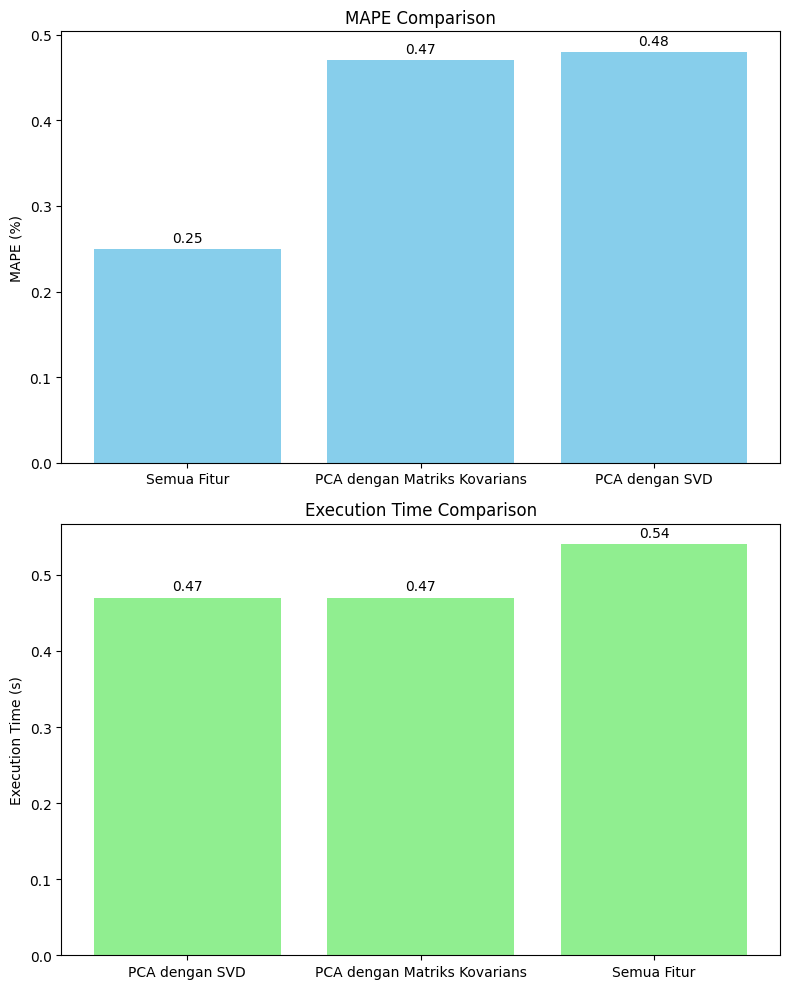

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the image
data = {
    "Method": [
        "Semua Fitur",
        "PCA dengan SVD",
        "PCA dengan Matriks Kovarians"
    ],
    "MAPE (%)": [0.25, 0.48, 0.47],
    "Execution Time (s)": [0.54, 0.47, 0.47]
}

# Create DataFrame
df = pd.DataFrame(data)

# Sort by MAPE
df_sorted_mape = df.sort_values(by="MAPE (%)")
df_sorted_time = df.sort_values(by="Execution Time (s)")

# Plot barplots with vertical orientation and annotations
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# MAPE Barplot
bars_mape = ax[0].bar(df_sorted_mape["Method"], df_sorted_mape["MAPE (%)"], color='skyblue')
ax[0].set_title('MAPE Comparison')
ax[0].set_ylabel('MAPE (%)')

# Add annotations for MAPE
for bar in bars_mape:
    height = bar.get_height()
    ax[0].annotate(f'{height:.2f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom')

# Execution Time Barplot
bars_time = ax[1].bar(df_sorted_time["Method"], df_sorted_time["Execution Time (s)"], color='lightgreen')
ax[1].set_title('Execution Time Comparison')
ax[1].set_ylabel('Execution Time (s)')

# Add annotations for Execution Time
for bar in bars_time:
    height = bar.get_height()
    ax[1].annotate(f'{height:.2f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()
